![image](https://www.cncf.io/wp-content/uploads/2018/10/dotscience.svg)

# Home Credit Default Risk

## Data

We are using data provided by [Home Credit](http://www.homecredit.net/about-us.aspx) a service dedicated to provided lines of credit (loans) to the unbanked population. 

There are 7 sources of data. We track them all as `ds.input`s:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)


## Imports

In [188]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# get dotscience
import dotscience as ds



In [189]:
%matplotlib inline

# Start logging with Dotscience

In [190]:
ds.interactive()
ds.start()

## Read in Data 


In [191]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(os.getcwd()) if (isfile(join(os.getcwd(), f)) and f.endswith('csv'))]

In [192]:
# Start tracking files with Dotscience
for file in onlyfiles:
    ds.input(file)

In [193]:
# Training data
app_train = pd.read_csv('application_train.csv')
app_train.rename(columns={'SK_ID_CURR':'Loan_ID'}, inplace=True) 
print('Training data shape: ', app_train.shape)
app_train.head()

# Or, uncomment this to see all the features
# with pd.option_context("display.max_columns", 122):
#    print(app_train.head())

Training data shape:  (307511, 122)


,Loan_ID,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [194]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
app_test.rename(columns={'SK_ID_CURR':'Loan_ID'}, inplace=True)
print('Testing data shape: ', app_test.shape)
app_test.head()



Testing data shape:  (48744, 121)


,Loan_ID,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

## Examine the Distribution of the Target

0 indicates that the loan was repaid on time. 1 indicates that the client had payment difficulties.

In [195]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

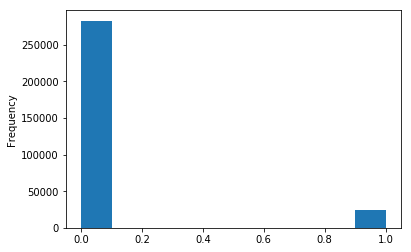

In [196]:
app_train['TARGET'].astype(int).plot.hist();

## Encode Categorical Variables

For any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [197]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [198]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

We want to retain the same features (columns) in both the training and testing data. So, let's encode the test data in the same way as the training data.

In [199]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

## Correlations

### Correlation with `TARGET` label

In [200]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Correlation between features
Let's dig into some initially promising sounding features. We'll see how they are related, and how each one is distributed.

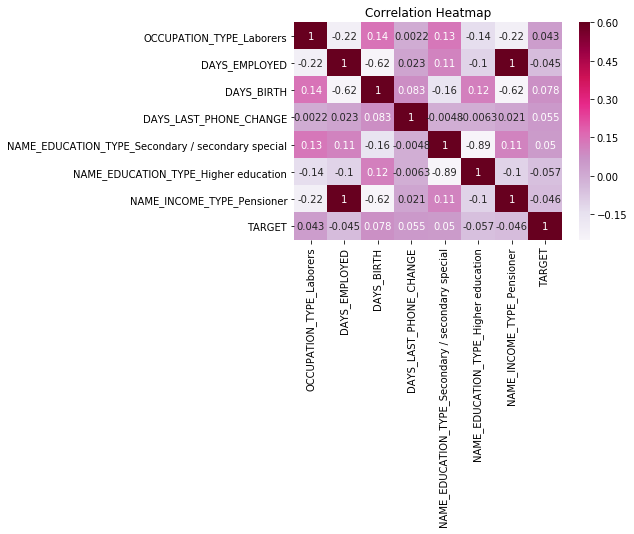

In [201]:
reduced_df = app_train[['OCCUPATION_TYPE_Laborers', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_INCOME_TYPE_Pensioner', 'TARGET',]]

corrs = reduced_df.corr()
# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.PuRd, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0bf9d446a0>,
      dtype=object)

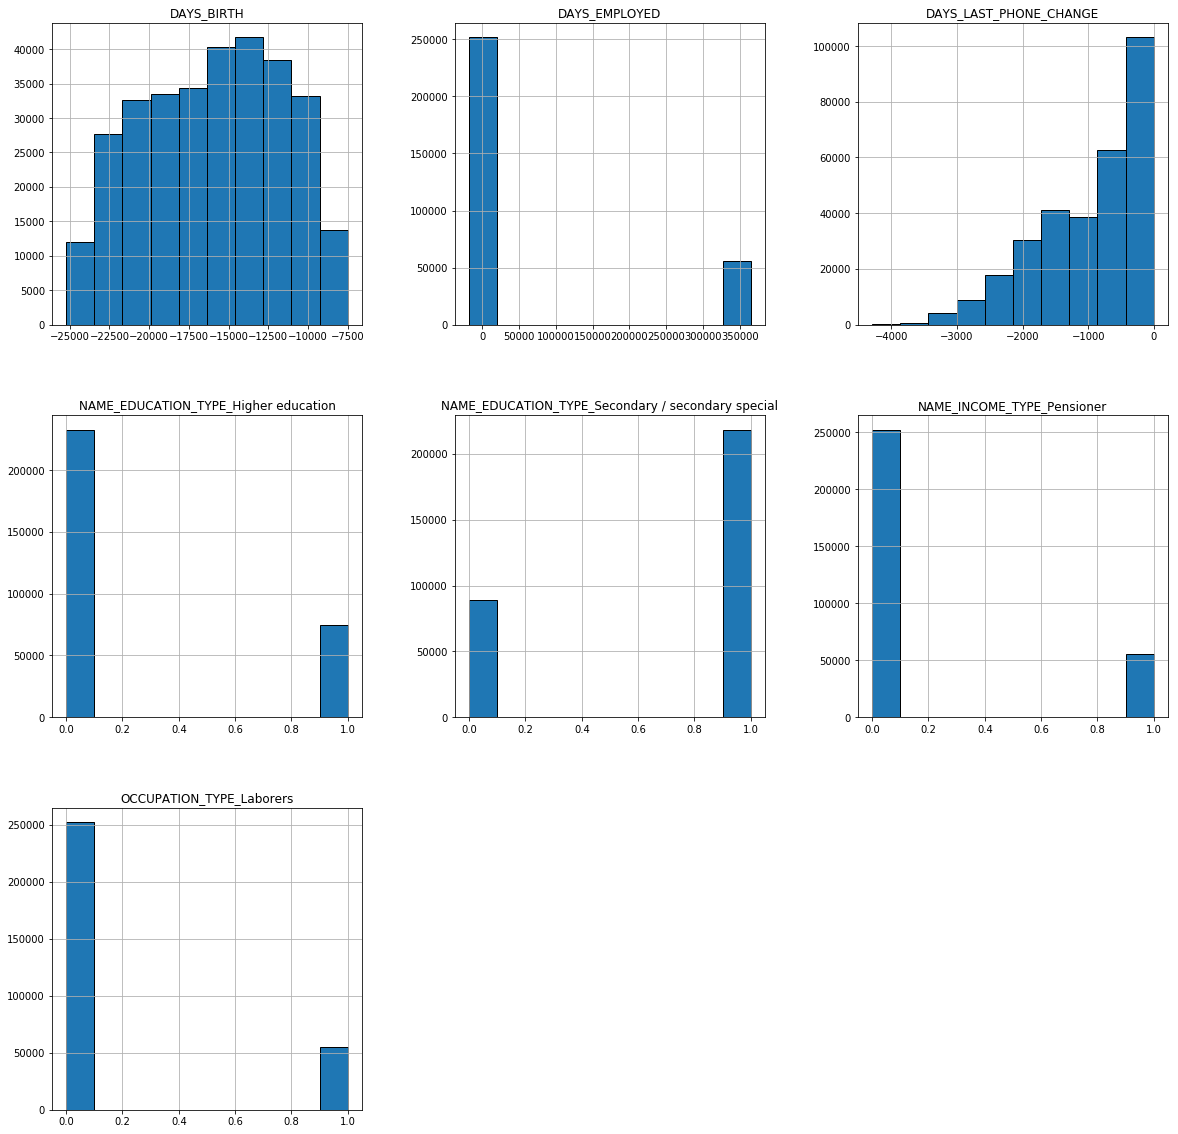

In [202]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
app_train[['OCCUPATION_TYPE_Laborers', 'DAYS_EMPLOYED', 
           'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 
           'NAME_EDUCATION_TYPE_Secondary / secondary special', 
           'NAME_EDUCATION_TYPE_Higher education', 
           'NAME_INCOME_TYPE_Pensioner']].hist(ax = ax, edgecolor = 'k')



### Effect of Age on Repayment

We can dig into one feature in particular...

In [203]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 


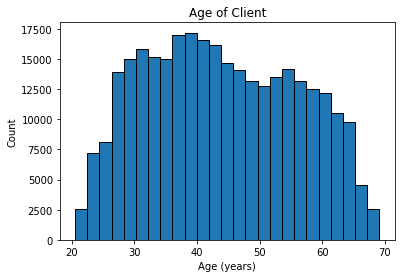

In [204]:
# plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

The distribution of age shows that there are no outliers.

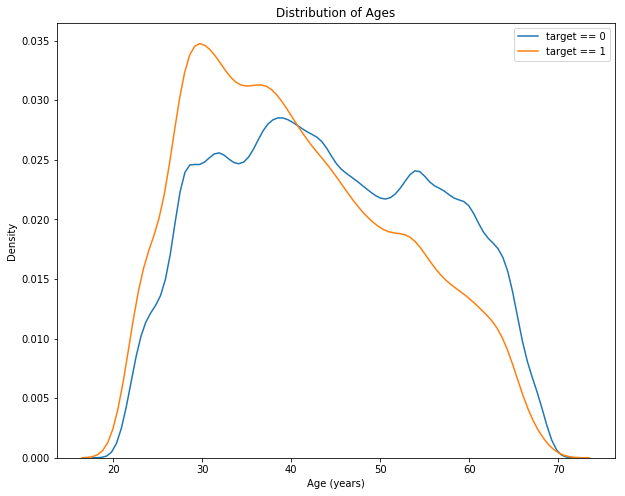

In [205]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The `TARGET == 1` curve skews towards the younger end of the range. 

In [206]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Let's write this out to csv
age_data.to_csv('repayment_by_age_group.csv', index = False)
ds.add_output('repayment_by_age_group.csv')

In [207]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


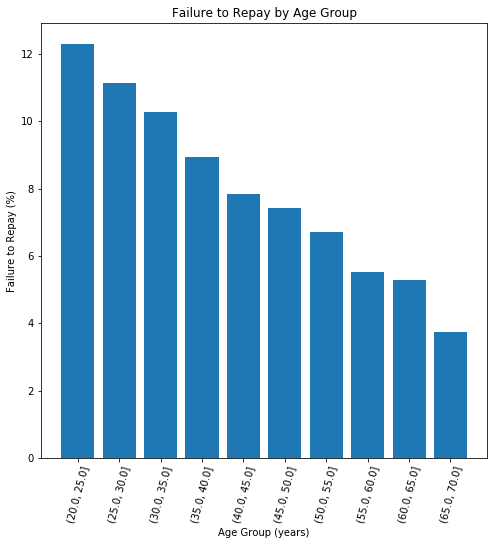

In [208]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to default on the loan. The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank.

# Make the model

We implement a [random forest model with Scikit-Learn](https://scikit-learn.org/stable/modules/ensemble.html#forest). We want to predict probabilities (floats in the range [0, 1]) that unlabeled clients will default on credit repayments.

### Preprocessing
We fill in missing values with the median of their respective columns (imputation) and normalize the feature ranges (scaling).

In [209]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


## Train the model and get summary metrics
We use a random forest model.

We can parameterise with the number of trees to build, `max_features` to use, and with [warm_start](https://scikit-learn.org/stable/glossary.html#term-warm-start). We set `n_jobs` to -1 to use all available cores.

In [210]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
# NB setting n_jobs to -1 will take advantage of all processors to run jobs in parallel
random_forest = RandomForestClassifier(n_estimators = ds.parameter("n_estimators", 100), random_state = 50, 
                                       verbose = 1, n_jobs = -1, oob_score=True, warm_start = (ds.parameter("warm_start", True)))
#random_forest.fit(train, train_labels)


Use `ds.summary()` to grab the model's accuracy metric, returned by its `.score()` method. For a random forest model, this is the mean accuracy score. If we had more time to run the model, we could use cross validation to get a metric value instead instead.

In [211]:
# Train on the training data
%time random_forest.fit(train, train_labels)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished


CPU times: user 38.9 s, sys: 799 ms, total: 39.7 s
Wall time: 10.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=50, verbose=1, warm_start=True)

In [212]:
# Get out of bag score
print(ds.summary("out_of_bag_score", random_forest.oob_score_))

0.9072846174608388


## Make predictions
We want to predict the probability of defaulting, so we use the model's `predict.proba` method. This returns an `m` x 2 array where `m` is the number of test records. The first column is the probability of the target being 0 (indicating no default) and the second column is the probability of the target being 1 (indicating a default), so for a single row, the two columns must sum to 1. 

We will output the probability the loan is _not_ repaid, so we select the second column.

In [213]:
# Make predictions on the test data
%time rand_forest_predictions = random_forest.predict_proba(test)[:, 1]

CPU times: user 373 ms, sys: 0 ns, total: 373 ms
Wall time: 127 ms


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


### Output predictions to csv

In [214]:
predictions_df = app_test[['Loan_ID']]
predictions_df['TARGET'] = rand_forest_predictions

# Save the dataframe as a csv
predictions_df.to_csv('random_forest_predictions.csv', index = False)
ds.add_output('random_forest_predictions.csv')

In [215]:
predictions_df.head()

,Loan_ID,TARGET
0,100001,0.0
1,100005,0.1
2,100013,0.0
3,100028,0.2
4,100038,0.3


The predictions show the probability that the loan will not be repaid. The user of the model can chose a threshold beyond which the risk of default is too high, and use this data to make lending decisions.

In [216]:
ds.publish()

[[DOTSCIENCE-RUN:b0a87bcd-de12-4d2a-b03b-50d4d68573dd]]{
    "end": "20190218T174237.277112",
    "input": [
        "repayment_by_age_group.csv",
        "bureau_balance.csv",
        "random_forest_predictions.csv",
        "previous_application.csv",
        "credit_card_balance.csv",
        "application_test.csv",
        "application_train.csv",
        "bureau.csv",
        "sample_submission.csv",
        "POS_CASH_balance.csv",
        "installments_payments.csv"
    ],
    "labels": {},
    "output": [
        "repayment_by_age_group.csv",
        "random_forest_predictions.csv"
    ],
    "parameters": {
        "n_estimators": "10",
        "warm_start": "True"
    },
    "start": "20190218T173837.212877",
    "summary": {
        "out_of_bag_score": "0.9072846174608388"
    },
    "version": "1"
}[[/DOTSCIENCE-RUN:b0a87bcd-de12-4d2a-b03b-50d4d68573dd]]
